In [12]:
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio as rio
from rasterio import features
from glob import glob
import os
from tqdm import tqdm

In [2]:
# Combining the two into one dataframe
def merge_shp_bnd(shp,bbnd):
    shp = shp.set_index("GEOID10")
    shp.index = shp.index.map(int)
    
    bbnd = bbnd.set_index("FIPS")
    bbnd.index = bbnd.index.map(int)
    return shp.merge(bbnd,left_index=True, right_index=True, how="inner")

def lteraster_from_sat(lte, path):
    with rio.open(path) as dataset:
        
        satimg = dataset.read()
        mask = dataset.dataset_mask()
        sat_trs = dataset.transform
        sat_crs = dataset.crs

        results = (
            {'properties': {'raster_val': v}, 'geometry': s}
            for i, (s, v) 
            in enumerate(
                rio.features.shapes(mask, transform=dataset.transform)))

    sat = gpd.GeoDataFrame.from_features(list(results),crs=sat_crs)
    
    lte = lte.to_crs(sat_crs)
    ovr = gpd.overlay(sat,lte)
    
    shapes = [(geom,value) for geom, value in zip(ovr["geometry"],ovr["4G_LTE"])]
    return features.rasterize(shapes,np.shape(satimg[0]),transform=sat_trs)


In [26]:
%%time
states = ["ak"]
states_group = "-".join(states)

actual477 = pd.concat([pd.read_csv("./fcc477actual/{}_201906.csv".format(s.upper())) for s in states])
block_paths = ["./shapefiles/censusblocks/{}/tabblock10.shp".format(s) for s in states]
censusblocks = gpd.GeoDataFrame(pd.concat([gpd.read_file(i) for i in block_paths], ignore_index=True), crs=gpd.read_file(block_paths[0]).crs)

Wall time: 2min 23s


In [27]:
%%time
merged = merge_shp_bnd(censusblocks,actual477)

Wall time: 5.25 s


In [28]:
open_path = glob("./sentinel2/{}/composite/*.tif".format(states_group))
save_path = "./fcc477actual/sentinel2/{}/npz/".format(states_group)
if not os.path.isdir(save_path): os.makedirs(save_path)

for path in tqdm(open_path):
    sat_id = path.split("\\")[1].split(".")[0]
    lteraster = lteraster_from_sat(merged, path)
    np.savez_compressed(save_path+sat_id,lteraster)

  0%|          | 0/6 [00:00<?, ?it/s]C:\Users\Tyler\anaconda3\envs\cs230\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
 17%|█▋        | 1/6 [08:55<44:39, 535.86s/it]C:\Users\Tyler\anaconda3\envs\cs230\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
 33%|███▎      | 2/6 [15:46<33:13, 498.44s/it]C:\Users\Tyler\anaconda3\envs\cs230\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


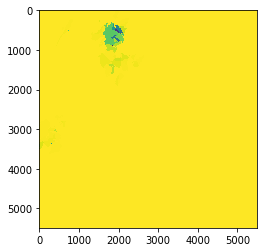

In [29]:
%pylab
%matplotlib inline
imshow(lteraster)